## Recommender system project

In current, work I will create recommender system of text posts. As raw data, I will use the following tables:

**user_data:**

| Field name  | Overview  |
|---|---|
| age  | User age (in profile)  |
| city  | User city (in profile)  |
| country  | User country (in profile)  |
| exp_group  | Experimental group: some encrypted category  |
| gender  | User Gender  |
| id  | Unique user ID  |
| os | The operating system of the device from which the social network is used  |
| source  | Whether the user came to the app from organic traffic or from ads  |

**post_text_df:**

| Field name | Overview |
|---|---|
| id  | Unique post ID  |
| text  | Text content of the post  |
| topic  | Main theme |

**feed_data**:

| Field name  | Overview  |
|---|---|
| timestamp  | The time the viewing was made  |
| user_id | id of the user who viewed the post |
| post_id  | viewed post id  |
| action  | Action Type: View or Like  |
| target  | Views have 1 if a like was made almost immediately after viewing, otherwise 0. Like actions have a missing value.  |

### Import required libraries

In [35]:
import re
import string
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from catboost import CatBoostClassifier

In [2]:
warnings.filterwarnings("ignore")

### Database connection and used tables overview

In this work PostgreSQL was used as a RDBMS. I created `connection` variable for datebase access. When publishing a project on `github`, it will be removed. To demonstrate the work of the web service, a small part of the processed data will be given.

In [3]:
connection = "<PostgreSQL connection>"

Get user data.

In [4]:
user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",

    con=connection
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


Posts and topics.

In [5]:
posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con=connection
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


Also we have the `feed_data` table, which contains the data about users actions, e.g., like or view for a particular post. But this table is too big (it contains about 77 millions of entries, so I will use only a part of this dataset to avoid memory errors).

In [6]:
count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con=connection
)

count_feed_data.head()

,count
0,76892800


Let's take 1 million.

In [7]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 500000""",
    
    con=connection
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-20 18:06:11,61070,6076,view,0
1,2021-12-20 18:07:25,61070,1741,view,0
2,2021-12-20 18:09:22,61070,6967,view,0
3,2021-12-20 18:10:33,61070,1882,view,0
4,2021-12-20 18:13:25,61070,1056,view,0


### Work with the data and create features for content-based model

What is about the target column?

In [8]:
feed_data[feed_data.action!="view"].head()

,timestamp,user_id,post_id,action,target
12,2021-12-27 16:37:19,61070,4487,like,0
14,2021-12-27 16:38:44,61070,3712,like,0
19,2021-12-27 16:45:02,61070,2795,like,0
34,2021-12-27 17:05:14,61070,6565,like,0
38,2021-12-27 17:06:52,61070,2112,like,0


It is not interesting for us if `action != 'view'` because we want to learn to predict if `like` will occur after user's viewing the post. So let's remove such entries.

In [9]:
feed_data = feed_data[feed_data.action=="view"]

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-20 18:06:11,61070,6076,view,0
1,2021-12-20 18:07:25,61070,1741,view,0
2,2021-12-20 18:09:22,61070,6967,view,0
3,2021-12-20 18:10:33,61070,1882,view,0
4,2021-12-20 18:13:25,61070,1056,view,0


Recall how the content approach works. Learn from the selected date timestamp and for any pair of `(user_id, post_id)` predict whether a like will happen or not. It would be nice to have a model that can predict probabilities for this kind of problems.

Let's use original dataset (`user_info`)  as features for a particular user.

In [10]:
user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


`posts_info` is much more interesting. Let's come up with some kind of embedding for texts. I would like to use `TF-IDF` as a baseline.

In [11]:
posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


Create function for text preprocessing, get rid of punctuation, spaces and use lemmatization, and then use `TF-IDF` to create text embeddings.

In [12]:
wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace("\n\n", " ").replace("\n", " ")
    line = " ".join([token.lemmatize(x) for x in line.split(" ")])
    return line


tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=preprocessing
)

In [13]:
tfidf_data = tfidf \
             .fit_transform(posts_info["text"]) \
             .toarray()

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


46000 features are too many to work with, especially since most of the numbers in the table will be zeros. So I will create new features based on `TF-IDF` embeddings. First of all, let's use some aggregation functions to squeeze 46000 numbers to 1.

In [14]:
posts_info["total_tfidf"] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info["max_tfidf"] = tfidf_data.max(axis=1).reset_index()[0]
posts_info["mean_tfidf"] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


#### Hypothesis

Most likely our posts are not entirely unique, but form a certain set of different topics. We already have a `topic` column, but let's assume the following: if we could somehow cluster our posts, then we could use the distances to the centroid of each cluster as new features. Despite the fact that we have only 7 topics, let's take a larger number of clusters, for example, 15, because within one topic there can be several subtopics. We will use `KMeans`, but to speed up the algorithm before starting, we will reduce the number of features from 46000 to 20 using `PCA`.

In [15]:
# Transform the data via PCA
n_components = 20
centered = tfidf_data - tfidf_data.mean()
pca = PCA(n_components=n_components)
pca_decomp = pca.fit_transform(centered)

# Perform KMeans and calculate distances to each of 15 centroids
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)
posts_info["TextCluster"] = kmeans.labels_

dists_columns = [f"DistanceTo{i}thCluster" for i in range(1, n_clusters + 1)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.511129,0.501398,0.450679,0.478838,0.439834,0.533077,0.149345,0.452037,0.445147,0.389819,0.501781,0.453900,0.549919,0.526053,0.547377
1,0.395967,0.375541,0.309655,0.341904,0.292013,0.274722,0.257821,0.273430,0.281067,0.162994,0.421457,0.297187,0.453149,0.410783,0.448868
2,0.426184,0.388261,0.333265,0.361152,0.312907,0.479698,0.122269,0.320040,0.323341,0.232671,0.424038,0.344222,0.487990,0.433384,0.465781
3,0.391455,0.351565,0.272472,0.320652,0.261084,0.431864,0.221690,0.275902,0.283889,0.142515,0.401317,0.288930,0.447584,0.386746,0.429233
4,0.354054,0.295302,0.198177,0.259621,0.176269,0.393235,0.284689,0.192155,0.218031,0.105681,0.347791,0.241196,0.409045,0.340930,0.427165


Add new features to `posts_info`.

In [16]:
posts_info = pd.concat((posts_info, dists_df), axis=1)
posts_info.head()

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.511129,0.501398,0.450679,...,0.533077,0.149345,0.452037,0.445147,0.389819,0.501781,0.453900,0.549919,0.526053,0.547377
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,9,0.395967,0.375541,0.309655,...,0.274722,0.257821,0.273430,0.281067,0.162994,0.421457,0.297187,0.453149,0.410783,0.448868
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.426184,0.388261,0.333265,...,0.479698,0.122269,0.320040,0.323341,0.232671,0.424038,0.344222,0.487990,0.433384,0.465781
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.391455,0.351565,0.272472,...,0.431864,0.221690,0.275902,0.283889,0.142515,0.401317,0.288930,0.447584,0.386746,0.429233
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,9,0.354054,0.295302,0.198177,...,0.393235,0.284689,0.192155,0.218031,0.105681,0.347791,0.241196,0.409045,0.340930,0.427165


Create the table with all new features.

In [17]:
all_features = pd.merge(feed_data,
                        posts_info,
                        on="post_id",
                        how="left")

all_features = pd.merge(all_features,
                        user_info,
                        on="user_id",
                        how="left")

all_features.head()

,timestamp,user_id,post_id,action,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-12-20 18:06:11,61070,6076,view,0,With a cast of stalwart British character acto...,movie,9.017077,0.300247,0.000196,...,0.363030,0.378356,0.465030,0,53,Russia,Balabanovo,0,Android,ads
1,2021-12-20 18:07:25,61070,1741,view,0,Wilkinson return unlikely\n\nJonny Wilkinson l...,sport,7.590293,0.584247,0.000165,...,0.535553,0.501735,0.566377,0,53,Russia,Balabanovo,0,Android,ads
2,2021-12-20 18:09:22,61070,6967,view,0,OK lets get right to the point. We have five r...,movie,9.423149,0.376976,0.000205,...,0.433296,0.364010,0.430145,0,53,Russia,Balabanovo,0,Android,ads
3,2021-12-20 18:10:33,61070,1882,view,0,Ferguson rues failure to cut gap\n\nBoss Sir A...,sport,7.833527,0.382008,0.000170,...,0.460366,0.421075,0.505511,0,53,Russia,Balabanovo,0,Android,ads
4,2021-12-20 18:13:25,61070,1056,view,0,Councils must find Gypsy sites\n\nMinisters ar...,politics,9.076526,0.507884,0.000197,...,0.427199,0.369746,0.450970,0,53,Russia,Balabanovo,0,Android,ads


It's time to extract features from `timestamp` variable. Agree, the tendency of users to like or ignore certain posts may depend on the viewing time.

In [19]:
all_features["hour"] = pd.to_datetime(all_features["timestamp"]) \
                         .apply(lambda x: x.hour)
all_features["month"] = pd.to_datetime(all_features["timestamp"]) \
                          .apply(lambda x: x.month)

all_features.head()

,timestamp,user_id,post_id,action,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-12-20 18:06:11,61070,6076,view,0,With a cast of stalwart British character acto...,movie,9.017077,0.300247,0.000196,...,0.465030,0,53,Russia,Balabanovo,0,Android,ads,18,12
1,2021-12-20 18:07:25,61070,1741,view,0,Wilkinson return unlikely\n\nJonny Wilkinson l...,sport,7.590293,0.584247,0.000165,...,0.566377,0,53,Russia,Balabanovo,0,Android,ads,18,12
2,2021-12-20 18:09:22,61070,6967,view,0,OK lets get right to the point. We have five r...,movie,9.423149,0.376976,0.000205,...,0.430145,0,53,Russia,Balabanovo,0,Android,ads,18,12
3,2021-12-20 18:10:33,61070,1882,view,0,Ferguson rues failure to cut gap\n\nBoss Sir A...,sport,7.833527,0.382008,0.000170,...,0.505511,0,53,Russia,Balabanovo,0,Android,ads,18,12
4,2021-12-20 18:13:25,61070,1056,view,0,Councils must find Gypsy sites\n\nMinisters ar...,politics,9.076526,0.507884,0.000197,...,0.450970,0,53,Russia,Balabanovo,0,Android,ads,18,12


Remove unnecessary columns.

In [20]:
all_features = all_features.drop(["action", "text"], axis=1)
all_features = all_features.set_index(["user_id", "post_id"])
all_features.head()

timestamp  target     topic  total_tfidf  max_tfidf  \
user_id post_id                                                                 
61070   6076    2021-12-20 18:06:11       0     movie     9.017077   0.300247   
        1741    2021-12-20 18:07:25       0     sport     7.590293   0.584247   
        6967    2021-12-20 18:09:22       0     movie     9.423149   0.376976   
        1882    2021-12-20 18:10:33       0     sport     7.833527   0.382008   
        1056    2021-12-20 18:13:25       0  politics     9.076526   0.507884   

                 mean_tfidf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                  
61070   6076       0.000196            4              0.380446   
        1741       0.000165           10              0.454424   
        6967       0.000205            4              0.370375   
        1882       0.000170            8              0.396844   
        1056       0.000197            9              0.387460   

                 DistanceTo2thCluster  DistanceTo3thCluster  ...  \
user_id post_id                                              ...   
61070   6076                 0.224036              0.251821  ...   
        1741                 0.456875              0.418120  ...   
        6967                 0.239233              0.223242  ...   
        1882                 0.341032              0.309917  ...   
        1056                 0.326918              0.239240  ...   

                 DistanceTo15thCluster  gender  age  country        city  \
user_id post_id                                                            
61070   6076                  0.465030       0   53   Russia  Balabanovo   
        1741                  0.566377       0   53   Russia  Balabanovo   
        6967                  0.430145       0   53   Russia  Balabanovo   
        1882                  0.505511       0   53   Russia  Balabanovo   
        1056                  0.450970       0   53   Russia  Balabanovo   

                 exp_group       os  source  hour  month  
user_id post_id                                           
61070   6076             0  Android     ads    18     12  
        1741             0  Android     ads    18     12  
        6967             0  Android     ads    18     12  
        1882             0  Android     ads    18     12  
        1056             0  Android     ads    18     12  

[5 rows x 31 columns]

### Train baseline model

Let's take the `Decision tree` as a baseline model, and then move on to `Catboost`, since we have a large number of categorical features. Also note that the data has a time structure and therefore a simple split into train and test will not work, nor will the usual `KFold` cross validation. For simplicity, let's split it into a train and a test for some time threshold (we could do `TimeSeriesSplit`, but we'll focus on a simpler option).

In [21]:
max(all_features.timestamp), min(all_features.timestamp)

(Timestamp('2021-12-29 23:33:53'), Timestamp('2021-10-01 06:07:30'))

In [23]:
### Take 2021-12-15 as a threshold

all_features_train = all_features[all_features.timestamp < "2021-12-15"]
all_features_test = all_features[all_features.timestamp >= "2021-12-15"]

all_features_train = all_features_train.drop("timestamp", axis=1)
all_features_test = all_features_test.drop("timestamp", axis=1)

X_train = all_features_train.drop("target", axis=1)
X_test = all_features_test.drop("target", axis=1)

y_train = all_features_train["target"]
y_test = all_features_test["target"]

print(f"The number of train samples: {y_train.shape}, and test samples: {y_test.shape}")

THe number of train samples: (368495,), and test samples: (77393,)


Fit `Decision tree`.

In [26]:
object_cols = [
    "topic", "TextCluster", "gender", "country",
    "city", "exp_group", "hour", "month",
    "os", "source"
]

# Features for one hot encoding
cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
# Features for mean target encoding
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

# Save indexes of object columns
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ("OneHotEncoder", OneHotEncoder(), cols_for_ohe_idx),
    ("MeanTargetEncoder", TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

Let's measure the performance of such a model. As soon as we want to optimize the `Hit Rate` metric, and it is important for us to correctly rank our samples based on probabilities to be liked by user, let's use `ROC AUC` as a proxy metric to evaluate the performance of of models.


In [37]:
print(f"Quality on train: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Quality on test: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Quality on train: 0.9279120342086715
Quality on test: 0.5283599911072406


Seems like we are overfitted, so let's go for the next part and train `Catboost` model.

In [33]:

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3615514	total: 66.4ms	remaining: 6.58s
1:	learn: 0.3568064	total: 136ms	remaining: 6.68s
2:	learn: 0.3525724	total: 221ms	remaining: 7.13s
3:	learn: 0.3514425	total: 279ms	remaining: 6.7s
4:	learn: 0.3509529	total: 330ms	remaining: 6.28s
5:	learn: 0.3508360	total: 389ms	remaining: 6.1s
6:	learn: 0.3507146	total: 447ms	remaining: 5.94s
7:	learn: 0.3497762	total: 506ms	remaining: 5.82s
8:	learn: 0.3495988	total: 567ms	remaining: 5.74s
9:	learn: 0.3495298	total: 628ms	remaining: 5.65s
10:	learn: 0.3494049	total: 677ms	remaining: 5.48s
11:	learn: 0.3492321	total: 723ms	remaining: 5.3s
12:	learn: 0.3491395	total: 775ms	remaining: 5.19s
13:	learn: 0.3483861	total: 827ms	remaining: 5.08s
14:	learn: 0.3479112	total: 871ms	remaining: 4.94s
15:	learn: 0.3478121	total: 916ms	remaining: 4.81s
16:	learn: 0.3477700	total: 959ms	remaining: 4.68s
17:	learn: 0.3476663	total: 1.01s	remaining: 4.6s
18:	learn: 0.3476198	total: 1.05s	remaining: 4.5s
19:	learn: 0.3475735	total: 1.1s	remaining: 4

Let's measure the performance of a new model.

In [36]:
print(f"Train quality: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Test quality: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Quality on train: 0.6699365329037947
Quality on test: 0.6419928196515134


Now it is much better. Out of curiosity, let's look at `feature_importance`.

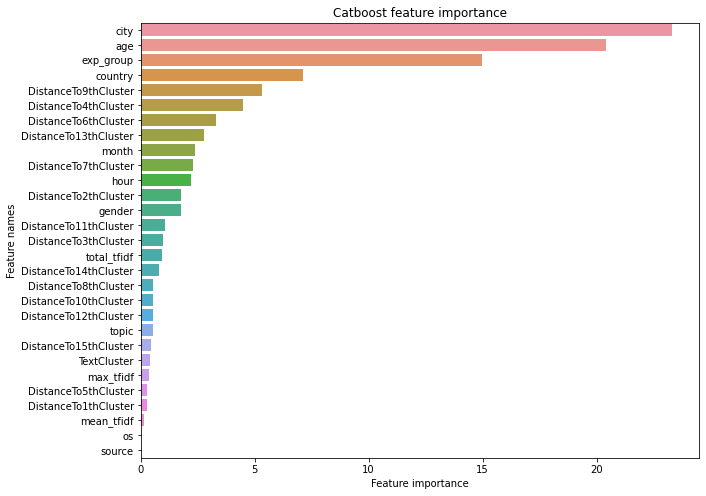

In [39]:
feature_importance = np.array(catboost.feature_importances_)
feature_names = np.array(X_train.columns)

data={"feature_names": feature_names, "feature_importance": feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
plt.title(f"Catboost feature importance")
plt.xlabel("Feature importance")
plt.ylabel("Feature names")

plt.show()

It is interesting that we can rid of `os` and `source` variables, because they have 0 importance.

### Save fitted model

In [40]:
catboost.save_model(
    "catboost_model_tf_idf",
    format="cbm"                  
)

### Put extracted features in database

In [41]:
posts_info.to_sql(    
   "posts_info_features_tf_idf",                    
    con=connection,                      
    schema="public",                   
    if_exists="replace"            
   )                     

In [42]:
### Check if everything is correct?

test_ = pd.read_sql(
    """SELECT * FROM public.posts_info_features_tf_idf""",
    
    con=connection
)

test_.head()

,index,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.511129,0.501398,...,0.533077,0.149345,0.452037,0.445147,0.389819,0.501781,0.453900,0.549919,0.526053,0.547377
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,9,0.395967,0.375541,...,0.274722,0.257821,0.273430,0.281067,0.162994,0.421457,0.297187,0.453149,0.410783,0.448868
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.426184,0.388261,...,0.479698,0.122269,0.320040,0.323341,0.232671,0.424038,0.344222,0.487990,0.433384,0.465781
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.391455,0.351565,...,0.431864,0.221690,0.275902,0.283889,0.142515,0.401317,0.288930,0.447584,0.386746,0.429233
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,9,0.354054,0.295302,...,0.393235,0.284689,0.192155,0.218031,0.105681,0.347791,0.241196,0.409045,0.340930,0.427165


**Results:**

1. Collected data from database
2. Conducted EDA
3. Created baseline model using features from `TF-IDF` embeddings
4. Planned to apply Transformers to create more valuable text embeddings in the future